# Part 1: Classification on simple pathology dataset

In [ ]:
!pip install medmnist

: 

In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [ ]:
n_classes

9

In [ ]:
print(train_dataset)
print("\n===================\n")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K

In [ ]:
# visualization

train_dataset.montage(length=1)

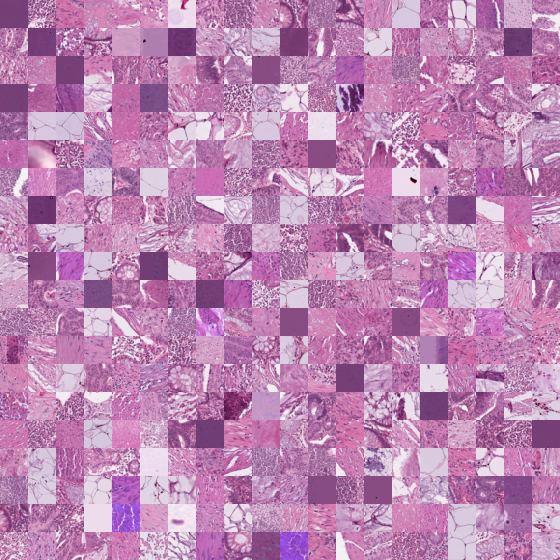

In [ ]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [ ]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
# To GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#
device

device(type='cuda')

## Next, we can start to train and evaluate!

In [ ]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [00:12<00:00, 58.22it/s]


In [ ]:
# evaluation

def test(split="train", data_loader=None):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu()
        y_score = y_score.cpu()

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        evaluator.labels = y_true
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

In [ ]:
print('==> Evaluating ...')
test("train", train_loader_at_eval)
test("test",test_loader)

==> Evaluating ...
train  auc: 0.995  acc:0.904
test  auc: 0.956  acc:0.713


## Let's attack the models !

**TODO 1**: Using ART library (https://github.com/Trusted-AI/adversarial-robustness-toolbox), compare the effectiveness of FGSM and PGD (50 iterations) attacks on the model. Use eps=8/255 and step=2/255

In [4]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.8 MB/s eta 0:00:00


In [ ]:
from art.attacks.evasion import ProjectedGradientDescentPyTorch, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

nb_images = 100
images_to_attack, labels = np.stack([img for img, _ in test_dataset])[:nb_images], [lbl for _, lbl in test_dataset][:nb_images]

In [ ]:
##1  set up PyTorchClassifier

cls_pgd = PyTorchClassifier(
    model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 28, 28),
    nb_classes=9,
)

cls_fsgm = cls_pgd.clone_for_refitting()

##2 ProjectedGradientDescentPyTorch / FastGradientSignDescentPyTorch
atk_pgd = ProjectedGradientDescentPyTorch(cls_pgd, eps=8/255, eps_step=2/255, max_iter=50)
atk_fgsm = FastGradientMethod(estimator=cls_fsgm, eps=8/255)

##3 xxx.generate()

adv_images_pgd = atk_pgd.generate(x=images_to_attack)
adv_images_fgsm = atk_fgsm.generate(x=images_to_attack)

PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import Dataset

class NumpyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        # Convert numpy -> Tensor if not already
        if not torch.is_tensor(img):
            img = torch.from_numpy(img)
        if not torch.is_tensor(label):
            label = torch.tensor(label)
        if self.transform:
            img = self.transform(img)
        return img, label

adv_loader_pgd = data.DataLoader(dataset=NumpyDataset(adv_images_pgd, labels), batch_size=2*BATCH_SIZE, shuffle=False)
adv_loader_fgsm = data.DataLoader(dataset=NumpyDataset(adv_images_fgsm, labels), batch_size=2*BATCH_SIZE, shuffle=False)
test("test", adv_loader_pgd)
test("test", adv_loader_fgsm)

test  auc: 0.403  acc:0.050
test  auc: 0.422  acc:0.050


#### Comparison:
PGD attack reduces significantly the accuracy of the model, especially when compared to the fgsm attack (18% accuracy vs 40% accuracy).\
AUC follows the exam same pattern, as they are related.\
Concluding, PGD attack seems to be more effective against our model than FSGM attack.

**TODO 2**: Extend the training code using adversarial training using FGSM for the same number epochs as before, attack again the model, and evaluate its new performances. Compare with the performance under TODO 1, and discuss.

In [ ]:
model_adv_train = Net(in_channels=n_channels, num_classes=n_classes)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_adv_train.parameters(), lr=lr, momentum=0.9)
classifier = PyTorchClassifier(
    model_adv_train,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 28, 28),
    nb_classes=9,
)

fgsm = FastGradientMethod(estimator=classifier, eps=8/255)

## Adversarial training for NUM_EPOCHS = 10 with FGSM
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        ## Create adversarial examples
        adv_inputs = fgsm.generate(x=inputs.numpy())
        adv_inputs = torch.from_numpy(adv_inputs).to(device)

        inputs, targets = inputs.to(device), targets.to(device)

        # forward + backward + optimize
        optimizer.zero_grad()

        # forward pass with clean/adversarial examples
        outputs = model(inputs)
        outputs = model(adv_inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

adv_images = fgsm.generate(x=images_to_attack)

adv_loader = data.DataLoader(dataset=NumpyDataset(adv_images, labels), batch_size=2*BATCH_SIZE, shuffle=False)
test("test", adv_loader)

100%|██████████| 704/704 [00:28<00:00, 24.77it/s]


test  auc: 0.915  acc:0.570


#### Discussion
The AUC has somewhat increased after adversarial training against fgsm (from 0.873 to 0.915), accuracy also increased considerably (from 40% to 57%)
Although the increase wasn't shocking, it is still effective to train the model against adversarial examples, nonetheless for a real model, adversarial training would probably benefit from training against stronger adversarial models.

# Part 2: Brain segmentation

This second part shows how to construct a training workflow of multi-labels segmentation task.

And it contains below features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](https://github.com/Project-MONAI/tutorials/blob/main/figures/brats_tasks.png?raw=1)

The image patches show from left to right:
1. the whole tumor (WT, in yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (TC, in red) visible in T2 (Fig.B).
1. the enhancing tumor structures (ET, in light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

**All the code to prepare the dataset and train the model is provided, you only need to write new code for attacking the model.**

**FOR THIS PART, YOU NEED TO SWITCH TO GPU RUNTIME**

**The maximum execution for GPU with a free account is 12h.**

**There is a weekly free quota of 15h-20h / week, so do not wait for the last minute to do the homework!**

**If you don't have any quota switch to CPU using the code below. It will be significantly slower when using only CPU**

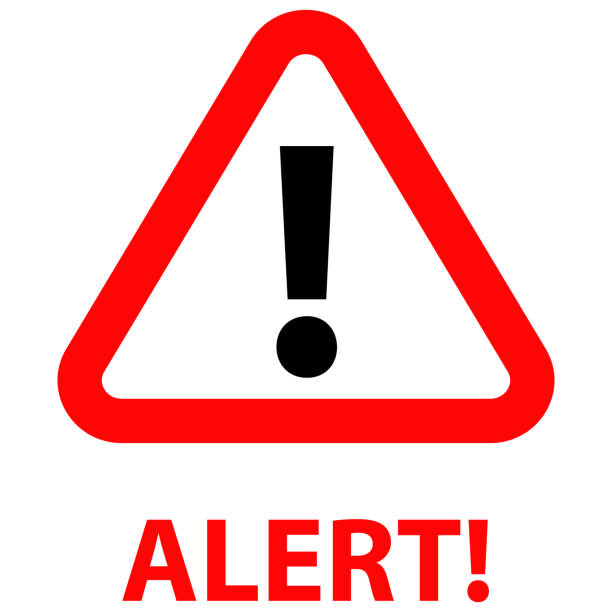

In [ ]:
sys_device = "cuda:0"

# uncomment the following to use cpu only, but you need to adapt amp
# sys_device = "cpu"

In [5]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import onnxruntime" || pip install -q onnxruntime
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 49.0 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'onnxruntime'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 135.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.5 MB/s eta 0:00:00


In [10]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch

sys_device = "cuda:0"

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [11]:
os.environ["MONAI_DATA_DIRECTORY"] = "."
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

set_determinism(seed=0)

.


## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [12]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

## Setup transforms for training and validation

In [13]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

/usr/local/lib/python3.12/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size.

In [14]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=2,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=2,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

2025-11-06 13:38:00,664 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-11-06 13:38:00,665 - INFO - File exists: Task01_BrainTumour.tar, skipped downloading.
2025-11-06 13:38:00,666 - INFO - Non-empty folder exists in Task01_BrainTumour, skipped extracting.


## Create Model, Loss, Optimizer

In [15]:
max_epochs = 5
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device(sys_device)
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


/tmp/ipython-input-3132300594.py:44: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## Execute a typical PyTorch training process

In [ ]:
# It should take 15min for one epoch

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()

        print(inputs.shape)
        print(labels.shape)
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

import pickle
savedata = {
    "best_metric" : best_metric,
    "best_metric_epoch" : best_metric_epoch,
    "best_metrics_epochs_and_time" : best_metrics_epochs_and_time,
    "epoch_loss_values" : epoch_loss_values,
    "metric_values" : metric_values,
    "metric_values_tc" : metric_values_tc,
    "metric_values_wt" : metric_values_wt,
    "metric_values_et" : metric_values_et,
}

with open(os.path.join(root_dir, "train_history.pkl"), "wb") as f:
    pickle.dump(savedata, f)
torch.save(model.state_dict(), './model_weights.pth')
torch.save(model, './full_model.pth')

----------
epoch 1/5
torch.Size([1, 4, 224, 224, 144])
torch.Size([1, 3, 224, 224, 144])


/tmp/ipython-input-22627117.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e88a6319620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wai

OutOfMemoryError: CUDA out of memory. Tried to allocate 442.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 190.12 MiB is free. Process 105410 has 14.55 GiB memory in use. Of the allocated memory 14.33 GiB is allocated by PyTorch, and 86.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

NameError: name 'best_metric' is not defined

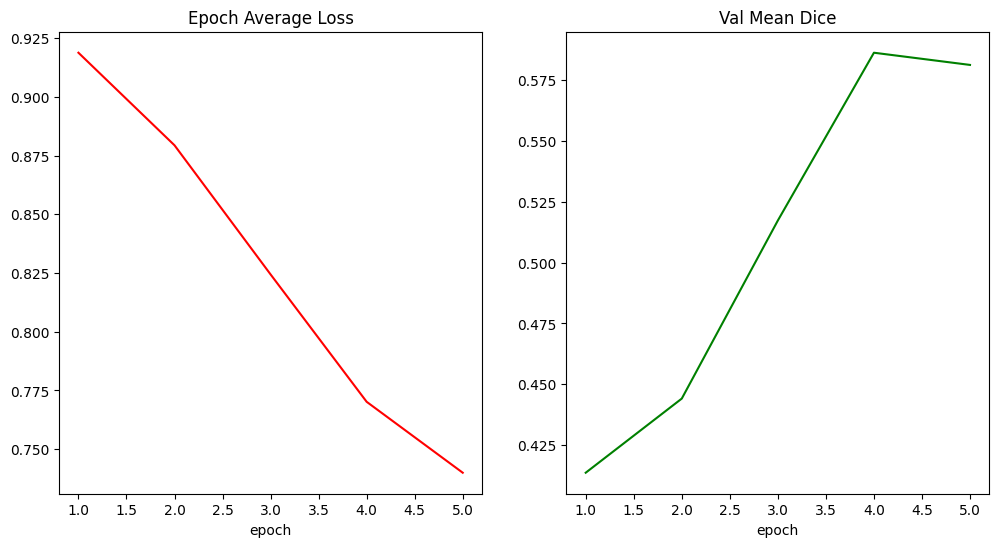

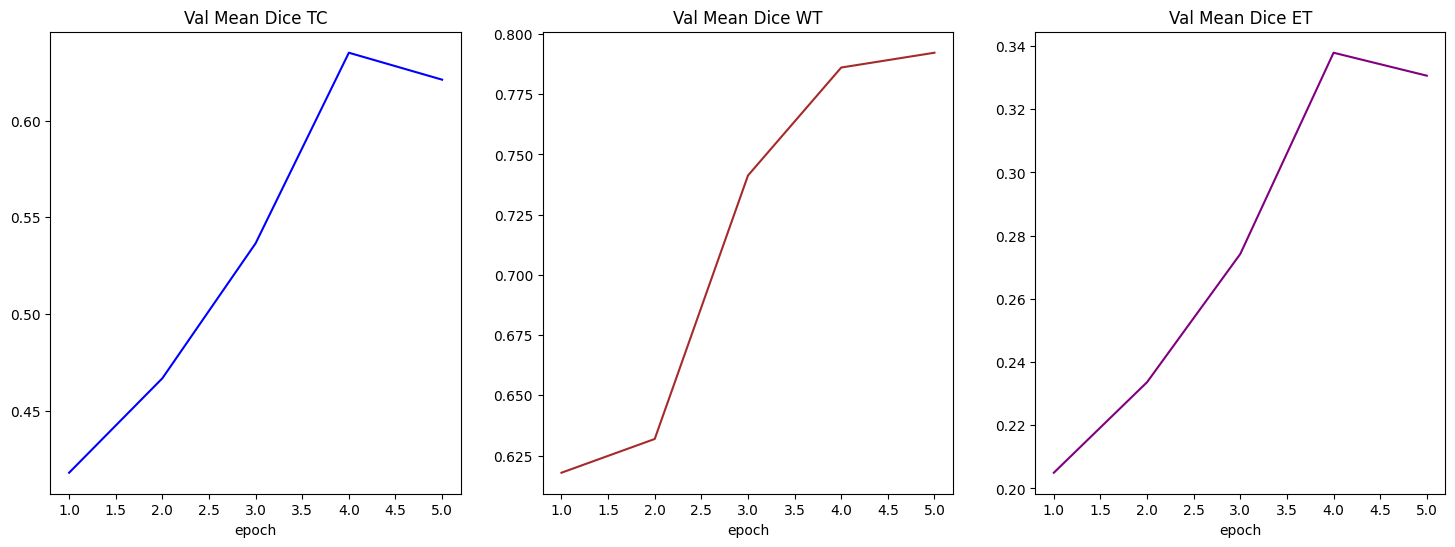

In [ ]:
import pickle
import os
# Values saved in Google-Colab
with open("./train_history.pkl", "rb") as f:
    savedata = pickle.load(f)

    best_metric = savedata["best_metric"]
    best_metric_epoch = savedata["best_metric_epoch"]
    best_metrics_epochs_and_time = savedata["best_metrics_epochs_and_time"]
    epoch_loss_values = savedata["epoch_loss_values"]
    metric_values = savedata["metric_values"]
    metric_values_tc = savedata["metric_values_tc"]
    metric_values_wt = savedata["metric_values_wt"]
    metric_values_et = savedata["metric_values_et"]

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

**TODO 3:** Train the model for at least 10 epochs. When does each class stop improving?

Discuss how each "task" evolves with training epochs. Can we achieve high segmentation performances for all tasks?

In [ ]:
## FILL HERE THE DISCUSSION
total_start = time.time()
for epoch in range(5, 16):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{16}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model_15.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 6/16
/tmp/ipython-input-578018973.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
1/388, train_loss: 0.6357, step time: 1.1638
2/388, train_loss: 0.8766, step time: 1.1239
3/388, train_loss: 0.6053, step time: 1.2139
4/388, train_loss: 0.6509, step time: 1.1749
5/388, train_loss: 0.7324, step time: 1.1551
6/388, train_loss: 0.9232, step time: 1.0417
7/388, train_loss: 0.6423, step time: 1.0426
8/388, train_loss: 0.7685, step time: 1.1614
9/388, train_loss: 0.7311, step time: 1.3477
10/388, train_loss: 0.5179, step time: 1.2223
11/388, train_loss: 0.6580, step time: 1.0893
12/388, train_loss: 0.7001, step time: 1.1535
13/388, train_loss: 0.8587, step time: 1.0941
14/388, train_loss: 0.6165, step time: 1.0530
15/388, train_loss: 0.7558, step time: 1.2157
16/388, train_loss: 0.6230, step time: 1.1334
17/388, train_loss: 0.6555, step time: 1.1602
18/388, trai

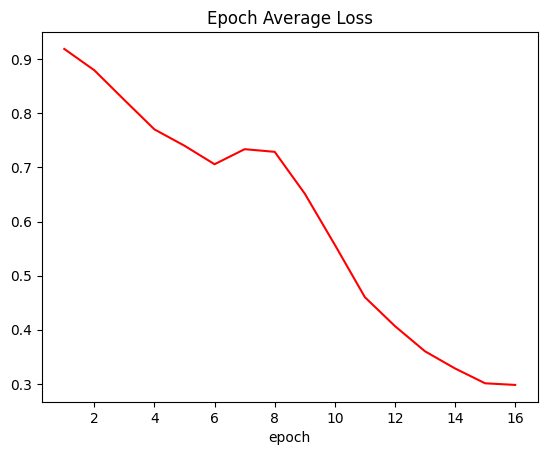

In [ ]:
# Manually adding the loss from the epochs training because arrays were not saved
epoch_loss_values += [
    0.7058,
    0.7336,
    0.7287,
    0.6515,
    0.5570,
    0.4602,
    0.4068,
    0.3602,
    0.3285,
    0.3011,
    0.2981
]

plt.figure("train")
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")

## FILL HERE THE DISCUSSION
# The loss value kept decreasing over the additional epochs,
# indicating that the model kept learning from the data.
# No significant plateau was observed.
# However, on the final epochs, the rate of decrease slowed down,
# suggesting that it is possibly approaching one.

# The remaining metrics were lost due to the google colab session closing and the runtime being reset, such that I cannot comment on them.

## Attacking the model

You can reuse your previous model or the checkpoint we provide.

In [16]:
## Either use your last model or "best_metric_practical.pth" provided in the practical for the following steps
#model.load_state_dict(torch.load(os.path.join(".", "best_metric_model.pth")))
model.load_state_dict(torch.load(os.path.join(".", "best_metric_practical.pth")))

<All keys matched successfully>

**TODO4:** Adapt the FGSM attack from TODO1 for the segmentation models.  Be careful about the shape and parameters of the ART classifier. Attack 10 volumes from the validation data loader then evaluate the performance of the models on this new adversarial set. You will need to adapt the SegResnet Model to be attackable

BONUS: Discuss the performance change of each class and try to explain the behaviour and the risks

HINT: Observe the shape of each input, we will build an attack on the voxel to change the prediction.

In [7]:
batch_data = next(iter(train_loader))
inputs, labels = (
    batch_data["image"],
    batch_data["label"],
)
[1, 3, 224, 224, 144]
print(f"Datapoint shapes:\nInputs - {inputs.shape}\nLabels - {labels.shape}")

NameError: name 'train_loader' is not defined

In [ ]:
## TODO4: FILL HERE THE CODE FOR THE ATTACK
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
import numpy as np
model.to(sys_device)


nb_images = 10
images_to_attack, labels = np.zeros((nb_images, *inputs.shape[1:]), dtype=np.float32), np.zeros((nb_images, *labels.shape[1:]), dtype=np.float32)
dataset_iter = iter(train_loader)
for i in range(nb_images):
    train_data = next(dataset_iter)
    img, label = (
        train_data["image"],
        train_data["label"],
    )
    images_to_attack[i] = np.array(img)
    labels[i] = np.array(label)

classifier = PyTorchClassifier(
    model,
    loss=loss_function,
    optimizer=optimizer,
    input_shape=inputs.shape[1:],
    nb_classes=4
)


fgsm = FastGradientMethod(estimator=classifier, eps=8/255, batch_size=1)

In [19]:
import gc
del batch_data, inputs, train_data, img, label, dataset_iter
gc.collect()
torch.cuda.empty_cache()

In [20]:
adv_images = fgsm.generate(x=images_to_attack)

In [22]:
import pickle
with open("./adv_images.pkl", "wb") as f:
  pickle.dump(adv_images, f)

In [24]:
# Redefining class because of multiple failures before.
from torch.utils.data import Dataset
import torch.utils.data as data

class NumpyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        # Convert numpy -> Tensor if not already
        if not torch.is_tensor(img):
            img = torch.from_numpy(img)
        if not torch.is_tensor(label):
            label = torch.tensor(label)
        if self.transform:
            img = self.transform(img)
        return img, label

adv_img_loader = data.DataLoader(dataset=NumpyDataset(adv_images, labels), batch_size=1, shuffle=False)

model.eval()
l_metric = []
l_metric_tc = []
l_metric_wt = []
l_metric_et = []

with torch.no_grad():
    for val_data in adv_img_loader:
        val_inputs, val_labels = val_data
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = inference(val_inputs)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric = dice_metric.aggregate().item()
    metric_batch = dice_metric_batch.aggregate()

    metric_tc = metric_batch[0].item()
    metric_wt = metric_batch[1].item()
    metric_et = metric_batch[2].item()

    l_metric.append(metric)
    l_metric_tc.append(metric_tc)
    l_metric_wt.append(metric_wt)
    l_metric_et.append(metric_et)

    dice_metric.reset()
    dice_metric_batch.reset()

/tmp/ipython-input-3132300594.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq

In [25]:
import pickle
with open("./attack_results.pkl", "wb") as f:
  data = {
      "l_metric" : l_metric,
      "l_metric_tc" : l_metric_tc,
      "l_metric_wt" : l_metric_wt,
      "l_metric_et" : l_metric_et
  }
  pickle.dump(data, f)

In [6]:
import pickle
with open("./attack_results.pkl", "rb") as f:
    data = pickle.load(f)

mean_metric = sum(data["l_metric"]) / len(data["l_metric"])
mean_metric_tc = sum(data["l_metric_tc"]) / len(data["l_metric_tc"])
mean_metric_wt = sum(data["l_metric_wt"]) / len(data["l_metric_wt"])
mean_metric_et = sum(data["l_metric_et"]) / len(data["l_metric_et"])


print("""After 5 epochs of training we got the following reference values on clean data:
Reference values:
Mean dice was at 0.575
Mean Dice TC was at 0.6
Mean dice WT was at 0.78
Mean Dice ET was at 0.33
""")

print(f"Adversarial Attack Results:\nMean Dice: {mean_metric:.3f}\nTC Dice: {mean_metric_tc:.3f}\nWT Dice: {mean_metric_wt:.3f}\nET Dice: {mean_metric_et:.3f}")

After 5 epochs of training we got the following reference values on clean data:
Reference values:
Mean dice was at 0.575
Mean Dice TC was at 0.6
Mean dice WT was at 0.78
Mean Dice ET was at 0.33

Adversarial Attack Results:
Mean Dice: 0.559
TC Dice: 0.504
WT Dice: 0.857
ET Dice: 0.316


## BONUS: FILL HERE THE DISCUSSION FOR THE ATTACK

Overall the attack was pretty unsuccessful, something must have went wrong, as even though TC and ET metrics degraded, Mean Dice and WT Dice got better with no training, which hints at an attack failure or a logic failure on my part.
Looking at the parts that got degraded, we can see that the attack was somewhat mild, it didnt affect the performance by much.
All of this could also hint that the attack didn't even do anything to the images